In [1]:
import numpy as np
import pandas as pd
import csv
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from matplotlib import cm
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from numpy import inf
from sklearn.metrics.pairwise import cosine_similarity
import umap
import networkx as nx
import json
import pyreadr
import ast
import obonet
import joblib
import scipy.stats as stats
import networkx as nx
from sklearn.preprocessing import Normalizer
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import neo4j
from IPython.display import Latex
import torch
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from collections import defaultdict
import numpy as np
from torch.nn import Linear
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from neo4j import GraphDatabase
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero
import gzip
from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected, RandomLinkSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import random
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
torch.cuda.is_available()

True

In [4]:
DB_NAME='graph.db'
url='bolt://localhost:7687'
user='neo4j'
password = 'NeO4JNeO4J'
driver = GraphDatabase.driver(url, auth=(user, password))

In [5]:
seed = 42

## PREPROCESSING

In [6]:
#def fetch_data(query, params={}):
#  with driver.session() as session:
#    result = session.run(query)
#    return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [8]:

query="""MATCH (n:Gene) 
RETURN ID(n), n.name, n.id, labels(n), n.type, n.synonyms, n.description, n.`fastrp-embedding` 
"""
with driver.session(database=DB_NAME) as session:
    df = pd.DataFrame(session.read_transaction( lambda tx: tx.run(query).data()))
    
df.to_feather('gene.ftr')


In [9]:
query="""MATCH (n:Drug) 
RETURN ID(n), n.name, n.id, labels(n), n.type, n.synonyms, n.description, n.`fastrp-embedding` 
"""

with driver.session(database=DB_NAME) as session:
    df = pd.DataFrame(session.read_transaction( lambda tx: tx.run(query).data() ))

df.to_feather('Drug.ftr') #,compression='lz4')


In [10]:
query="""MATCH (n:Disease) 
RETURN ID(n), n.name, n.id, labels(n), n.type, n.synonyms, n.description, n.`fastrp-embedding` 
"""
with driver.session(database=DB_NAME) as session:
    disease_df = pd.DataFrame(session.read_transaction( lambda tx: tx.run(query).data()))
    
disease_df.to_feather('Disease.ftr')

In [11]:
query="""MATCH (n:Phenotype) 
RETURN ID(n), n.name, n.id, labels(n), n.type, n.synonyms, n.description, n.`fastrp-embedding` 
"""

with driver.session(database=DB_NAME) as session:
    phen_df = pd.DataFrame(session.read_transaction( lambda tx: tx.run(query).data() ))
phen_df.to_feather('Phenotype.ftr')
#phenotype_df

## INPUTS

In [12]:
gene_ftr = "gene.ftr"
phenotype_ftr = 'Phenotype.ftr'
phenotype_gene_tsv = "gene_to_phenotype_ckg.tsv"

### Loading the embedding and preprocessing the data

In [13]:
def filter_row_emb(x):
    if all(v == 0 for v in x):
        return 1
    else:
        return 0
    

def load_parse_ftr(ftr_file, node_name):
    df = pd.read_feather(ftr_file)
    
    column_name_dict = {
        'ID(n)': 'ID',
        'labels(n)': 'labels',
        'n.`fastrp-embedding`': 'fastrp_embedding',
        'n.description': 'description',
        'n.id': 'id',
        'n.name': 'name',
        'n.synonyms': 'synonyms',
        'n.type': 'type'
    }
    
    df = df.rename(columns=column_name_dict)
    
    df['fastrp_embedding'] = df['fastrp_embedding'].values
    df['keep'] = df['fastrp_embedding'].apply(filter_row_emb)
    df = df[df['keep'] == 0]
    df = df.reset_index(drop=True)
    
    data_df = df[['id', 'fastrp_embedding']]
    embedding_column = 'fastrp_embedding_' + node_name
    data_df.columns = [node_name, embedding_column]
    
    return data_df
    

### Loading the mapping files

In [14]:
def mapping_data(mapping_file, node_name1, node_name2):
    df =  pd.read_csv(mapping_file, header=0, sep='\t', quotechar='"', error_bad_lines=False)
    df = df[['START_ID', 'END_ID']]
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    df.columns = [node_name1, node_name2]
    df['labels'] = 1
    df['map'] = df[node_name1] + '_' + df[node_name2]
    return df
    


### Generating data table with connected nodes

In [15]:
class GenerateData:
    def __init__(self, phen_df, map_df, gene_df, val_df, total_links=120000, total_unlink_pairs=26, total_datapoints=80000):
        self.phen_df = phen_df
        self.map_df = map_df
        self.gene_df = gene_df
        self.val_df = val_df
        self.total_links = total_links
        self.total_unlink_pairs = total_unlink_pairs
        self.total_datapoints = total_datapoints
    
    def create_linked_df(self):
        df = pd.merge(self.phen_df, self.map_df, on='Phenotype', how='left')
        df = df[~df['Gene'].isna()]
        df = pd.merge(df, self.gene_df, on='Gene', how='left')
        df = df.dropna(subset=['fastrp_embedding_Gene', 'fastrp_embedding_Phenotype'])
        df = df.sample(n=self.total_links, random_state=seed).reset_index(drop=True)
        print(df.shape)
        return df
    
    def create_unlinked_df(self):
        gene_phen_dict = defaultdict(list)
        unique_ids = self.map_df['Phenotype'].unique().tolist()
        phen_gene_dict = self.map_df.groupby('Gene')['Phenotype'].agg(list).to_dict()
        for key, value in phen_gene_dict.items():
            non_connected_hp = list(set(unique_ids) - set(value))
            if len(non_connected_hp) < self.total_unlink_pairs:
                gene_phen_dict[key] = non_connected_hp
            else:
                non_connected_hp = random.sample(non_connected_hp, self.total_unlink_pairs)
                gene_phen_dict[key] = non_connected_hp
        phen_gene_nolink_df = pd.DataFrame.from_dict(gene_phen_dict, orient='index').stack().reset_index()
        phen_gene_nolink_df.columns = ['Gene', 'level_1', 'Phenotype']
        phen_gene_nolink_df = phen_gene_nolink_df.drop('level_1', axis=1)
        df = pd.merge(phen_gene_nolink_df, self.phen_df, on='Phenotype', how='left')
        df = pd.merge(df, self.gene_df, on='Gene', how='left')
        df['labels'] = 0
        df = df.dropna(subset=['fastrp_embedding_Gene', 'fastrp_embedding_Phenotype'])
        df = df.reset_index(drop=True)
        train_df, val_df = train_test_split(df, test_size=0.02, random_state=42)
        print(train_df.shape)
        return  train_df, val_df
    
    def process_val_data(self):
        test_data, val_data = self.create_unlinked_df()
        print("val data shape {0}".format(val_data.shape))
        #val_data = val_data.drop(['labels'], axis=1)
        self.val_df.columns = ['SL2_ID', 'Gene', 'Phenotype']
        self.val_df['Phenotype'] = self.val_df['Phenotype'].astype(str).str.split(',')
        self.val_df = self.val_df.explode('Phenotype')
        self.val_df = self.val_df.drop(['SL2_ID'], axis=1)
        #print(self.val_df)
        solved_gene_df = pd.merge(self.val_df, self.gene_df, on='Gene', how='left')
        #print(solved_gene_df)
        solved_gene_pheno_df = pd.merge(solved_gene_df, self.phen_df, on='Phenotype', how='left')
        genes_removed = set(solved_gene_pheno_df[solved_gene_pheno_df['fastrp_embedding_Gene'].isna()]['Gene'])
        phenotype_removed = set(solved_gene_pheno_df[solved_gene_pheno_df['fastrp_embedding_Phenotype'].isna()]['Phenotype'])
        solved_gene_pheno_df = solved_gene_pheno_df.dropna(subset=['fastrp_embedding_Gene', 'fastrp_embedding_Phenotype'])
        solved_gene_pheno_df = solved_gene_pheno_df.reset_index(drop=True)
        solved_gene_pheno_df['labels'] = 1
        validation_df = pd.concat([solved_gene_pheno_df, val_data])
        validation_df = validation_df.reset_index(drop=True)
        #validation_df = validation_df.drop(['SL2_ID'], axis=1)
        return validation_df

    
    def get_data(self):
        train_data, val_data_neg = self.create_unlinked_df()
        data_df = pd.concat([self.create_linked_df(), train_data])
        data_df['labels'] = data_df['labels'].astype(int)
        data_df =  data_df.drop(['map'], axis=1)
        val_data_pos = self.process_val_data()
        #val_data_phenotypes = self.process_val_data()['Phenotype']
        val_data_genes = list(set(val_data_pos['Gene'].tolist()))
        val_data_phenotypes = list(set(val_data_pos['Phenotype'].tolist()))
        #data_df = data_df[~data_df['Gene'].isin(val_data_genes)]
        print(data_df.shape)
        #data_df = data_df[~data_df['Phenotype'].isin(val_data_phenotypes)]
        data_test_df = data_df.copy()
        data_test_df = data_df.sample(n=self.total_datapoints)
        data_test_df = data_test_df.reset_index(drop=True)
        data_df['fastrp_embedding_Gene'] = data_df['fastrp_embedding_Gene'].tolist()
        data_df['fastrp_embedding_Phenotype'] = data_df['fastrp_embedding_Phenotype'].tolist()
        return data_test_df, data_df
    
    

### Generating data table for non-connected nodes

In [16]:
class Operations(object):
    
    def __init__(self, emb1, emb2):
        self.emb1 = emb1
        self.emb2 = emb2
    
    def __iter__(self):
        return self
    
    
    def embeddings1(self):
        return self.emb1
    
    def embeddings2(self):
        return self.emb2
    
    def average(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding + np.resize(df2_embedding, df1_embedding.shape)
        return x/2
        
    def euclidean_distance(self):
        df1_embedding = self.embeddings1()
        df2_embedding = self.embeddings2()
        x = np.linalg.norm(df1_embedding.tolist() - np.transpose(df2_embedding.tolist()))
        return x
        
    def Hadamard(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding * df2_embedding
        return x
        
    def L1(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding - np.resize(df2_embedding, df1_embedding.shape)
        return abs(x)
    
    def L2(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = df1_embedding - np.resize(df2_embedding, df1_embedding.shape)
        y = abs(x)
        y = np.square(y)
        return y

### Final data to use

In [169]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_recall_curve, auc

def calculate_confidence_interval(data, metric, n_bootstraps=1000, alpha=0.95):
    bootstrapped_metrics = []
    for _ in range(n_bootstraps):
        bootstrapped_data = resample(data, random_state=np.random.seed())
        print(bootstrapped_data)
        print(metric)
        metric_value = metric(bootstrapped_data)
        bootstrapped_metrics.append(metric_value)
    
    lower_percentile = (1.0 - alpha) / 2.0 * 100
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(bootstrapped_metrics, lower_percentile)
    upper_bound = np.percentile(bootstrapped_metrics, upper_percentile)
    
    return metric, lower_bound, upper_bound




def run_rf(X_train, X_test, y_train, y_test, operation):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    rf_predictions = rf.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    print(f"Accuracy: {rf_accuracy}")

    # Calculate the confusion matrix
    rf_cm = confusion_matrix(y_test, rf_predictions)
    #print("Confusion Matrix:")
    #print(rf_cm)

    # Predict probabilities of positive class for test data
    y_scores = rf.predict_proba(X_test)[:, 1]

    # Calculate precision and recall values at different thresholds
    rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test, y_scores)

    # Calculate AUCPR
    rf_aucpr = auc(rf_recall, rf_precision)
    print(f"AUCPR: {rf_aucpr}")

    metrics_data = {'Accuracy': rf_accuracy, 'AUCPR': rf_aucpr}
    alpha = 0.95  # 95% confidence interval
    for metric_name, metric_value in metrics_data.items():
        metric_value, lower_bound, upper_bound = calculate_confidence_interval(
            data=X_test, metric=metric_value, alpha=alpha)
        print(f"{metric_name} (95% CI): {metric_value:.2f} ({lower_bound:.2f}, {upper_bound:.2f})")
    
    metrics_df = pd.DataFrame({'Precision': rf_precision, 'Recall': rf_recall, 
                               'Method': "random_forest", 'AUCPR': rf_aucpr, 'link_prediction': operation,
                               'CI_lower': lower_bound, 'CI_upper': upper_bound})
    
    return metrics_df


def run_xgboost(X_train, X_test, y_train, y_test, operation):
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    xgb_predictions = xgb.predict(X_test)
    xgb_accuracy = accuracy_score(y_test, xgb_predictions)
    print(f"Accuracy: {xgb_accuracy}")

    xgb_cm = confusion_matrix(y_test, xgb_predictions)
    #print("Confusion Matrix:")
    #print(xgb_cm)

    # Predict probabilities of positive class for test data
    y_scores = xgb.predict_proba(X_test)[:, 1]

    xgb_precision, xgb_recall, xgb_thresholds = precision_recall_curve(y_test, y_scores)

    # Calculate AUCPR
    xgb_aucpr = auc(xgb_recall, xgb_precision)
    print(f"AUCPR: {xgb_aucpr}")

    # Calculate confidence intervals for accuracy and AUCPR
    alpha = 0.95  # 95% confidence interval
    metrics_data = {'Accuracy': xgb_accuracy, 'AUCPR': xgb_aucpr}
    for metric_name, metric_value in metrics_data.items():
        metric, lower_bound, upper_bound = calculate_confidence_interval(
            data=y_scores, metric=metric_value, alpha=alpha)
        print(f"{metric_name} (95% CI): {metric:.2f} ({lower_bound:.2f}, {upper_bound:.2f}")

    metrics_df = pd.DataFrame({'Precision': xgb_precision, 'Recall': xgb_recall, 
                               'Method': "XGboost", 'AUCPR': xgb_aucpr, 'link_predcition': operation,
                               'CI_lower': lower_bound, 'CI_upper': upper_bound})
    
    return metrics_df

def run_nb(X_train, X_test, y_train, y_test, operation, save=False):
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train, y_train)
    y_pred = nb_classifier.predict(X_test)
    
    # Evaluate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    if save:
        joblib.dump(nb_classifier, 'nb_model.pkl')
    # Predict probabilities of positive class for test data
    y_scores = nb_classifier.predict_proba(X_test)[:, 1]

    # Calculate precision and recall values at different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

    # Calculate AUCPR
    aucpr = auc(recall, precision)
    print(f"AUCPR: {aucpr}")

    # Calculate confidence intervals for accuracy and AUCPR
    metrics_data = {'Accuracy': accuracy, 'AUCPR': aucpr}
    alpha = 0.95  # 95% confidence interval
    for metric_name, metric_value in metrics_data.items():
        metric_value, lower_bound, upper_bound = calculate_confidence_interval(
            data=X_test, metric=metric_value, alpha=alpha)
        print(f"{metric_name} (95% CI): {metric_value:.2f} ({lower_bound:.2f}, {upper_bound:.2f}")

    metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 
                               'Method': "Naive_Bayes", 'AUCPR': aucpr, 'link_prediction': operation,
                               'CI_lower': lower_bound, 'CI_upper': upper_bound})
    
    return metrics_df


def run_MLP(X_train, X_test, y_train, y_test, operation, save=False):
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(64, 32, 16), activation='relu', solver='adam', random_state=42)
    mlp_classifier.fit(X_train, y_train)
    y_pred = mlp_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    if save:
        joblib.dump(mlp_classifier, 'mlp_model.pkl')
    # Predict probabilities of positive class for test data
    y_scores = mlp_classifier.predict_proba(X_test)[:, 1]
    #print(y_scores)
    # Calculate precision and recall values at different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

    # Calculate AUCPR
    aucpr = auc(recall, precision)
    print(f"AUCPR: {aucpr}")
    # Calculate confidence intervals for accuracy and AUCPR
    metrics_data = {'Accuracy': accuracy, 'AUCPR': aucpr}
    alpha = 0.95  # 95% confidence interval
    for metric_name, metric_value in metrics_data.items():
        metric_value, lower_bound, upper_bound = calculate_confidence_interval(
            data=X_test, metric=metric_value, alpha=alpha)
        print(f"{metric_name} (95% CI): {metric_value:.2f} ({lower_bound:.2f}, {upper_bound:.2f}")

    metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 
                               'Method': "MLP", 'AUCPR': aucpr, 'link_predcition': operation,
                               'CI_lower': lower_bound, 'CI_upper': upper_bound})
    
    return metrics_df


def run_xgboost_with_cv(X, y, operation):
    xgb = XGBClassifier()
    
    # Create a stratified K-fold cross-validator with 10 folds
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Use cross_val_score to perform 10-fold cross-validation
    accuracy_scores = cross_val_score(xgb, X, y, cv=cv, scoring='accuracy')
    aucpr_scores = cross_val_score(xgb, X, y, cv=cv, scoring='roc_auc')
    
    # Calculate confidence intervals for accuracy and AUCPR
    alpha = 0.95  # 95% confidence interval

    accuracy_lower_bound, accuracy_upper_bound = calculate_confidence_interval(accuracy_scores, alpha=alpha)
    aucpr_lower_bound, aucpr_upper_bound = calculate_confidence_interval(aucpr_scores, alpha=alpha)
    
    print(f"Accuracy (95% CI): {np.mean(accuracy_scores):.2f} ({accuracy_lower_bound:.2f}, {accuracy_upper_bound:.2f})")
    print(f"AUCPR (95% CI): {np.mean(aucpr_scores):.2f} ({aucpr_lower_bound:.2f}, {aucpr_upper_bound:.2f})")
    
    metrics_df = pd.DataFrame({
        'Method': "XGboost", 
        'Accuracy': np.mean(accuracy_scores),
        'AUCPR': np.mean(aucpr_scores),
        'CI_lower_accuracy': accuracy_lower_bound,
        'CI_upper_accuracy': accuracy_upper_bound,
        'CI_lower_aucpr': aucpr_lower_bound,
        'CI_upper_aucpr': aucpr_upper_bound,
        'link_predcition': operation
    })
    
    return metrics_df

# Usage:


In [151]:
def evaluate_models(array,data_df, operation):
    df = pd.DataFrame(array)
    X = df.iloc[:, 0:1024]
    y = data_df['labels']
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.4, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    #rf_metrics = run_rf(X_test, X_val, y_test, y_val)
    xg_metrics = run_xgboost(X_test, X_val, y_test, y_val, operation)
    if operation == 'L1':
        nb_metrics = run_nb(X_test, X_val, y_test, y_val, operation, save=True)
    else:
        nb_metrics = run_nb(X_test, X_val, y_test, y_val, operation)
    if operation == "hadarmard":
        mlp_metrics = run_MLP(X_test, X_val, y_test, y_val, operation, save=True)
    else:
        mlp_metrics = run_MLP(X_test, X_val, y_test, y_val, operation)
    metrics_df = pd.concat([xg_metrics, nb_metrics, mlp_metrics])
    return metrics_df

## Analysis

In [148]:
gene_df = load_parse_ftr(gene_ftr, "Gene")
phenotype_df =  load_parse_ftr(phenotype_ftr, "Phenotype")
solved_df = pd.read_csv("HPO_Gene_solves_filtered_withHP.txtg", sep='\t', header=None) 
phen_gene_df = mapping_data(phenotype_gene_tsv, "Gene", "Phenotype")

positive_label_list = list(set(phen_gene_df.map.to_list()))
data_generation =  GenerateData(phenotype_df,phen_gene_df, gene_df, solved_df)
#data_generation.get_data()
data_df, data_all_df = data_generation.get_data()



(120072, 5)
(120000, 6)
(120034, 5)
val data shape (2450, 5)
(240072, 5)


In [168]:
link_prediction =  Operations(data_df.fastrp_embedding_Phenotype.values, data_df.fastrp_embedding_Gene.values)
average_results = link_prediction.average()
hadamard_results = link_prediction.Hadamard()
L1_results = link_prediction.L1()
L2_results = link_prediction.L2()
hadarmard_metrics = evaluate_models(hadamard_results, data_df, 'hadarmard')
average_metrics = evaluate_models(average_results, data_df, 'Average')
L1_metrics = evaluate_models(L1_results, data_df, 'L1')
L2_metrics = evaluate_models(L2_results, data_df, 'L2')
result_df = pd.concat([hadarmard_metrics, average_metrics, L1_metrics, L2_metrics])
result_df['Method'] = result_df['Method'].astype('category')
g = sns.FacetGrid(result_df, col='link_prediction', height=3, hue='Method', col_wrap=2)

# Plot lineplot for 'total_bill' against 'tip' within each time category
g.map(sns.lineplot, 'Precision', 'Recall')
g.add_legend()

g.set_axis_labels('Precision', 'Recall')
#g.fig.suptitle('Precision vs Recall for Link prediction operations')

# Show the plot
plt.show()
print(result_df.groupby(['link_prediction', 'Method'])['AUCPR'].min())
print(data_df.labels.value_counts())

Accuracy: 0.83875
AUCPR: 0.9047982270851507
[0.16937584 0.01295954 0.32014668 ... 0.02819134 0.9926823  0.40325263]
0.83875


TypeError: 'numpy.float64' object is not callable

In [21]:
data_all_df.labels.value_counts()

0    120022
1    120000
Name: labels, dtype: int64

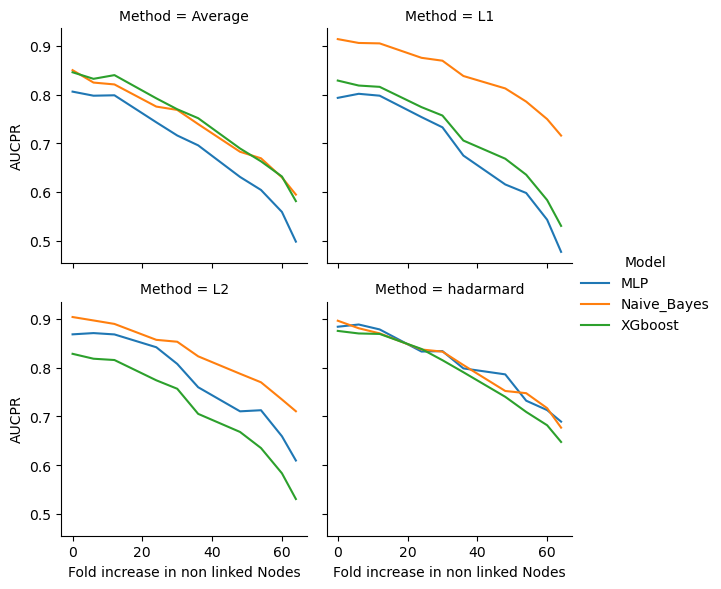

In [22]:
range_links_df = pd.read_csv("negative_links_increase.csv")


g = sns.FacetGrid(range_links_df, col='Method', height=3, hue='Model', col_wrap=2)

# Plot lineplot for 'total_bill' against 'tip' within each time category
g.map(sns.lineplot, 'precent_increase', 'AUCPR')
g.add_legend()

g.set_axis_labels('Fold increase in non linked Nodes', 'AUCPR')
#g.fig.suptitle('Precision vs Recall for Link prediction operations')

# Show the plot
plt.show()
#print(result_df.groupby(['link_predcition', 'Method'])['AUCPR'].min())
#print(data_df.labels.value_counts())


In [23]:
solved_df = pd.read_csv("HPO_Gene_solves_filtered_withHP.txtg", sep='\t', header=None) 
#solved_df
data_generation =  GenerateData(phenotype_df,phen_gene_df, gene_df, solved_df)
data_ind_df = data_generation.process_val_data()
data_ind_df.labels.value_counts()

(119991, 5)
val data shape (2449, 5)


0    2449
1    2062
Name: labels, dtype: int64

In [24]:

val_l1 = Operations(data_ind_df.fastrp_embedding_Phenotype.values, 
                             data_ind_df.fastrp_embedding_Gene.values)
val_l1_results = val_l1.L1()
loaded_model = joblib.load('nb_model.pkl')
X_independent_l1 = pd.DataFrame(val_l1_results)
nb_scores = loaded_model.predict(X_independent_l1)
nb_prob = loaded_model.predict_proba(X_independent_l1)
threshold = 0.5
probabilities = [prob[1] for prob in nb_prob]
data_ind_df['probabilities'] =probabilities
data_ind_df['nb_scores'] = nb_scores
accuracy = accuracy_score(data_ind_df.labels, data_ind_df.nb_scores)
print("Accuracy:", accuracy)
precision, recall, thresholds = precision_recall_curve(data_ind_df.labels, nb_scores)
#print(thresholds)
aucpr = auc(recall, precision)
print(f"AUCPR: {aucpr}")

Accuracy: 0.7537131456439814
AUCPR: 0.7934551402043605


In [25]:

all_data_l1 = Operations(data_all_df.fastrp_embedding_Phenotype.values,  data_all_df.fastrp_embedding_Gene.values)
val_alll1_results = all_data_l1.L1()
loaded_model = joblib.load('nb_model.pkl')
X_independent_l1 = pd.DataFrame(val_alll1_results)
nb_scores = loaded_model.predict(X_independent_l1)
nb_prob = loaded_model.predict_proba(X_independent_l1)
threshold = 0.5
probabilities = [prob[1] for prob in nb_prob]
data_all_df['probabilities'] =probabilities
data_all_df['nb_scores'] = nb_scores
accuracy = accuracy_score(data_all_df.labels, data_all_df.nb_scores)
print("Accuracy:", accuracy)
precision, recall, thresholds = precision_recall_curve(data_all_df.labels, nb_scores)
#print(thresholds)
aucpr = auc(recall, precision)
print(f"AUCPR: {aucpr}")

Accuracy: 0.8528259909508296
AUCPR: 0.8892674796871682


In [26]:
#plt.hist(data_ind_df.probabilities.values, bins='auto')
#plt.xlabel('Value')
#plt.ylabel('Frequency')
#plt.title('Distribution of Input Array')
#plt.show()
data_all_df = data_all_df[['Gene', 'Phenotype', 'probabilities']]
data_ind_df = data_ind_df[['Gene', 'Phenotype', 'probabilities']]
prob_df = pd.concat([data_ind_df, data_all_df])
prob_df = prob_df.drop_duplicates()
prob_df = prob_df.reset_index(drop=True)
prob_df.to_csv("L1_nb_prob.csv", index=False)
prob_df

,Gene,Phenotype,probabilities
0,CACNA1E,HP:0100022,2.769258e-09
1,CACNA1E,HP:0002072,8.541161e-06
2,CACNA1E,HP:0000750,8.270741e-01
3,CACNA1E,HP:0007359,2.082747e-02
4,CACNA1E,HP:0001263,9.965028e-01
...,...,...,...
244130,WNT10A,HP:0030299,5.736195e-02
244131,SPG11,HP:0010972,6.568867e-08
244132,ACACA,HP:0007862,1.751518e-06
244133,CCDC88C,HP:0002756,2.473437e-04


In [34]:

from pylatex import Document, Section, Subsection, Command


doc = Document()

# Add text
doc.append(Command('text', 'Let $E_{g}$ be the embedding for the gene nodes and $E_{p}$ be the embedding for the phenotype node.'))
doc.append('')

doc.append(Command('textbf', 'Hadamard'))
doc.append(' ')
doc.append('$(E_{g}, E_{p}) = f(E_{g}) \\cdot f(E_{p})$')
doc.append('')

doc.append(Command('textbf', 'Average'))
doc.append(' ')
doc.append('$(E_{g}, E_{p}) = \\frac{f(E_{g}) + f(E_{p})}{2}$')
doc.append('')

doc.append(Command('textbf', 'L1'))
doc.append(' ')
doc.append('$(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|$')
doc.append('')

doc.append(Command('textbf', 'L2'))
doc.append(' ')
doc.append('$(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|^2$')

print(doc)

#doc.generate_pdf('equations', clean_tex=False, compiler='pdflatex')


Document('default_filepath', [Command('normalsize', Arguments(), Options()), Command('text', Arguments('Let $E_{g}$ be the embedding for the gene nodes and $E_{p}$ be the embedding for the phenotype node.'), Options()), '', Command('textbf', Arguments('Hadamard'), Options()), ' ', '$(E_{g}, E_{p}) = f(E_{g}) \\cdot f(E_{p})$', '', Command('textbf', Arguments('Average'), Options()), ' ', '$(E_{g}, E_{p}) = \\frac{f(E_{g}) + f(E_{p})}{2}$', '', Command('textbf', Arguments('L1'), Options()), ' ', '$(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|$', '', Command('textbf', Arguments('L2'), Options()), ' ', '$(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|^2$'])


\documentclass{article}
\begin{document}


Let $E_{g}$ be the embedding for the gene nodes, and \\\
$E_{p}$ be the embedding for the phenotype node:

Hadamard $(E_{g}, E_{p}) = f(E_{g}) \cdot f(E_{p})$

Average $(E_{g}, E_{p}) = \frac{f(E_{g}) + f(E_{p})}{2}$

L1 $(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|$

L2 $(E_{g}, E_{p}) = |f(E_{g}-f(E_{t})|^2$

Cosine similarity:

Cosine Similarity$ = \frac{E_{g}^T \cdot E_{p}} {|E_{g}| \cdot |E_{p}|}$


Where $E_{g}^T$ is the transpose of embedding \\\
for gene nodes, and $E_{p}$ is the embedding \\\
for the phenotype node.


Dot Product$ = {E_{g}^T \cdot E_{p}} $


$IC_{p}$$ = \frac {N_{P}}{N}$

Where $N_{P}$ is the number of genes connected to the \\\
phenotye and $N$ is the total number of genes


Rank $= max(\sum_{p=1}^{n} $$\vec{h}$)


For all phenotypes $p$ for a given case $i$:

$\vec{h}$$ = -log_{2}(g|p) \cdot IC_{P} \cdot w_{p}$

$Rank$$ = \max(\sum $$\vec{h}$)

where $\vec{h}$ is the dot product of the negative log of &nbsp;&nbsp; &nbsp; \\\
the probablity measure from cosinse similarity,      &nbsp;&nbsp;&nbsp; \\\
Information content and the weighted coefficients             \\\
from link predictions for all given phenotypes 

 

\end{document}


###### MODEL

In [35]:
class RankQuery:
    def __init__(self, gene_df, phenotype_df, prob_df, filter_list):
        self.gene_df = gene_df
        self.phenotype_df = phenotype_df
        self.filter_list = filter_list
        self.prob_df = prob_df

    def embeddings1(self):
        return self.gene_df.fastrp_embedding_Gene.values

    def embeddings2(self):
        return self.phenotype_df.fastrp_embedding_Phenotype.values

    def dot_product(self):
        df1_embedding = self.embeddings1()
        df2_embedding = self.embeddings2()
        x = np.matmul(df1_embedding.tolist(), np.transpose(df2_embedding.tolist()))  # shape(15872, 3564)
        return x

    def cosine_similarity(self):
        df1_embedding = np.array(self.embeddings1().tolist())
        df2_embedding = np.array(self.embeddings2().tolist())
        x = cosine_similarity(df1_embedding, df2_embedding)  # shape(15872, 3564)
        return x

    def get_probability(self, query):
        try:
            probability = self.prob_df[self.prob_df['HPO'] == query]['PROBABILITIES'].values[0]
            return probability
        except IndexError:
            print("HPO {0} not found in the list of probabilities".format(query))
            return min(self.prob_df['PROBABILITIES'])

    def log_probability(self, query):
        try:
            probability = self.get_probability(query)
            log_probs = -math.log2(probability)
            return log_probs
        except TypeError:
            print("HPO {0} not found in the list of probabilities".format(query))
            exit()


    @staticmethod
    def stable_softmax(x):
        z = x - np.max(x,axis=1)[:,np.newaxis]
        numerator = np.exp(z)
        denominator = np.sum(numerator,axis=1)
        softmax = numerator/denominator[:,np.newaxis]
        return softmax

    def execute_softmax(self):
        #print(np.shape(self.inndot_product()))
        softmax = RankQuery.stable_softmax(self.dot_product())
        return softmax
    

    def create_dataframe_cosine(self):
        prob_table_df = self.prob_df.set_index('HPO')
        rownames = self.gene_df.Gene
        columns_order = self.phenotype_df.Phenotype.to_frame()
        columns_df = self.phenotype_df.Phenotype.to_frame().set_index('Phenotype')
        columns_df = columns_df.join(prob_table_df)
        columns_df = columns_df.fillna(np.nanmin(columns_df.to_numpy()))
        columns_df = columns_df.reindex(columns_order.Phenotype)
        finalmat = self.cosine_similarity() * columns_df.to_numpy().T
        final_df = pd.DataFrame(data=finalmat, index = rownames, columns=columns_order.Phenotype)
        return final_df
    
    def create_dataframe_dp(self):
        prob_table_df = self.prob_df.set_index('HPO')
        rownames = self.gene_df.Gene
        columns_order = self.phenotype_df.Phenotype.to_frame()
        columns_df = self.phenotype_df.Phenotype.to_frame().set_index('Phenotype')
        columns_df = columns_df.join(prob_table_df)
        columns_df = columns_df.fillna(np.nanmin(columns_df.to_numpy()))
        columns_df = columns_df.reindex(columns_order.Phenotype)
        finalmat = self.dot_product() * columns_df.to_numpy().T
        final_df = pd.DataFrame(data=finalmat, index = rownames, columns=columns_order.Phenotype)
        return final_df


In [36]:
class BayesRank(object):
    
    def __init__(self, phenotype_df, gene_df, prob_df):
        self.phenotype_df = phenotype_df # phenotype (hpo id and fastrp embedding)
        self.gene_df = gene_df # gene (gene id and fastrp embedding)
        self.prob_df = prob_df # probability (hpo_id and hpo_prob)
        #self.filter_df = filter_df
        #self.hpo_set = set(hpo_df.hpo_id.values)
        #self.gene_set = set(gene_df.gene_id.values)

    def inndot_product(self):
        df1_embedding = self.gene_df.fastrp_embedding_Gene.values
        df2_embedding = self.phenotype_df.fastrp_embedding_Phenotype.values #shape(15872, 3564)
        x = np.matmul(df1_embedding.tolist(), 
                         np.transpose(df2_embedding.tolist()))
        #x = preprocessing.normalize(x, norm='l2',axis=0)
        #Data_normalized = Data_normalizer.transform(array)
        return x
    
    @staticmethod
    def stable_softmax(x):
        z = x - np.max(x,axis=1)[:,np.newaxis]
        numerator = np.exp(z)
        denominator = np.sum(numerator,axis=1)
        softmax = numerator/denominator[:,np.newaxis]
        return softmax
    
    def execute_softmax(self):
        #print(np.shape(self.inndot_product()))
        softmax = BayesRank.stable_softmax(self.inndot_product())
        return softmax
    
    def create_dataframe(self):
        prob_table_df = self.prob_df.set_index('HPO')
        rownames = self.gene_df.Gene
        columns_order = self.phenotype_df.Phenotype.to_frame()
        columns_df = self.phenotype_df.Phenotype.to_frame().set_index('Phenotype')
        columns_df = columns_df.join(prob_table_df)
        columns_df = columns_df.fillna(np.nanmin(columns_df.to_numpy()))
        columns_df = columns_df.reindex(columns_order.Phenotype)
        print(columns_df)
        #print(self.execute_softmax())
        #finalmat = np.log(self.execute_softmax()/columns_df.to_numpy().T)
        finalmat = self.execute_softmax()/columns_df.to_numpy().T
        final_df = pd.DataFrame(data=finalmat, index = rownames, columns=columns_order.Phenotype)
        #print(final_df)
        return final_df

In [37]:
def stable_softmax(x):
    z = x - np.max(x,axis=1)[:,np.newaxis]
    numerator = np.exp(z)
    denominator = np.sum(numerator,axis=1)
    softmax = numerator/denominator[:,np.newaxis]
    return softmax

In [38]:
def stack_results(data, phen_df, gene_df):
    df = pd.DataFrame(np.vstack(data))
    rownames = phen_df.id
    colnames = gene_df.id
    df.columns = colnames
    df['Phenotype'] = rownames
    melt_df = pd.melt(df, id_vars='Phenotype')
    return melt_df

def balanced_data(df):
    seed = 42
    df['map'] = df['id'] + '_' + df['Phenotype']
    df_pos_df = df[df['map'].isin(positive_label_list)]
    df_neg_df = df[~df['map'].isin(positive_label_list)]
    df_pos_df = df_pos_df.sample(n=10000, random_state=seed)     
    df_neg_df = df_neg_df.sample(n=10000, random_state=seed)
    df_pos_df['labels'] = 1
    df_neg_df['labels'] = 0
    results_labels_df = pd.concat([df_pos_df, df_neg_df])
    return results_labels_df

In [39]:
probability_table_mayo_df = pd.read_csv("probabilities.csv")
probability_table_PCAN_df = pd.read_csv("PCAN_IC_normalized.csv")
ckg_hpo_count_df = pd.read_csv("CKG_HPO_connected_clinvar_genes_counts.tsv", sep="\t")
clinvar_genes_total = 3564
ckg_hpo_count_df.columns = ['index', 'count', 'HPO']
ckg_hpo_count_df['PROBABILITIES'] = ckg_hpo_count_df['count']/clinvar_genes_total
probability_ckg_df = ckg_hpo_count_df[["HPO", "PROBABILITIES"]]

gene_list_df = pd.read_csv("clinvarGenes.txt")
gene_list = gene_list_df['CLINVAR_GENES'].tolist()
#clinvar_genes_total = 3564
#ckg_hpo_count_df.columns = ['index', 'count', 'HPO']
#ckg_hpo_count_df['PROBABILITIES'] = ckg_hpo_count_df['count']/clinvar_genes_total
#probability_ckg_df = ckg_hpo_count_df[["HPO", "PROBABILITIES"]]

In [56]:
bayes_model = BayesRank(phenotype_df, gene_df, probability_ckg_df)
dp_cosine_model = RankQuery(gene_df, phenotype_df,probability_ckg_df, gene_list)
bayes_df = bayes_model.create_dataframe()
cs_df = dp_cosine_model.create_dataframe_cosine()
dp_df = dp_cosine_model.create_dataframe_dp()
#run_methods(test_df, bayes_df, dp_cosine_model, probability_ckg_df)  


            PROBABILITIES
Phenotype                
HP:0000001       0.000281
HP:0000002       0.004770
HP:0000003       0.028339
HP:0000005       0.000281
HP:0000006       0.409371
...                   ...
HP:3000075       0.000281
HP:3000076       0.000281
HP:3000077       0.000281
HP:3000078       0.000281
HP:3000079       0.000281

[15872 rows x 1 columns]


In [57]:
cs_df

Phenotype,HP:0000001,HP:0000002,HP:0000003,HP:0000005,HP:0000006,HP:0000007,HP:0000008,HP:0000009,HP:0000010,HP:0000011,...,HP:3000070,HP:3000071,HP:3000072,HP:3000073,HP:3000074,HP:3000075,HP:3000076,HP:3000077,HP:3000078,HP:3000079
Gene,,,,,,,,,,,,,,,,,,,,,
MIR34A,-3.838369e-06,0.000146,0.002595,6.937220e-06,0.037665,0.069465,0.000422,0.000009,0.001560,0.000786,...,0.000007,0.000007,1.233701e-05,-1.652622e-05,0.000010,2.225654e-05,1.936480e-06,7.997785e-06,0.000015,0.000010
HLA-DPA1,4.159135e-07,0.000533,0.003485,2.854575e-05,0.066295,0.098522,0.001871,0.000116,0.004467,0.000932,...,0.000005,0.000005,2.848702e-05,-1.195434e-05,0.000014,7.756673e-06,2.422622e-05,4.721234e-06,0.000006,0.000015
SF3A3,9.902197e-06,0.000778,0.004019,2.696981e-05,0.086579,0.101652,0.001976,0.000080,0.004682,0.001262,...,0.000010,0.000010,3.020123e-05,-3.269926e-06,0.000012,-6.682650e-06,1.615983e-05,2.456787e-05,0.000024,0.000023
CALN1,6.393042e-06,0.000504,0.002181,1.733394e-05,0.036708,0.082481,0.001665,0.000025,0.004127,0.000278,...,-0.000007,-0.000007,1.179251e-05,-2.950431e-06,0.000007,6.715542e-06,5.356145e-06,8.991045e-06,0.000010,0.000017
MIR4494,4.976135e-06,0.000179,-0.001058,3.651198e-06,-0.001572,-0.012571,0.000112,-0.000019,0.000122,0.000071,...,0.000006,0.000006,1.030200e-05,-1.822046e-06,-0.000017,1.830672e-07,-2.381664e-05,-1.233141e-06,-0.000007,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LINC01106,-1.631036e-05,0.000140,-0.000087,-1.103251e-05,0.005003,0.033451,0.000521,0.000090,0.000810,0.000112,...,-0.000003,-0.000003,-3.096979e-06,-5.110144e-06,0.000027,1.462617e-05,1.357623e-05,7.371329e-07,0.000002,0.000014
NTMT1,-2.460771e-06,0.000433,0.002484,1.859658e-05,0.050600,0.061229,0.001298,0.000136,0.002707,0.000761,...,-0.000008,-0.000008,1.765503e-05,1.555296e-05,0.000015,9.629152e-06,-1.120884e-05,2.430392e-05,0.000022,0.000027
PWRN3,-4.943182e-06,0.000005,-0.000617,-5.969068e-07,0.012718,0.003950,0.000494,0.000043,0.000440,0.000272,...,-0.000003,-0.000003,-3.994768e-06,-5.390694e-06,0.000007,-1.033945e-05,6.524947e-06,1.237580e-05,0.000010,0.000005


In [63]:
# Create the l1_ckg_df DataFrame
l1_ckg_df = pd.DataFrame(index=range(28158 ), columns=range(15872))
l1_ckg_df.columns = dp_df.columns
l1_ckg_df.index = dp_df.index

# Fill the values in l1_ckg_df using row and column indices
#for _, row in prob_df.iterrows():
#    gene_idx = row['Gene']
#    print(gene_idx)
#    phenotype_idx = row['Phenotype']
#    l1_ckg_df.at[gene_idx, phenotype_idx] = row['probabilities']
#l1_ckg_df = l1_ckg_df.fillna(0.01)
#l1_ckg_df.value_counts()

#prob_df
l1_ckg_df

Phenotype,HP:0000001,HP:0000002,HP:0000003,HP:0000005,HP:0000006,HP:0000007,HP:0000008,HP:0000009,HP:0000010,HP:0000011,...,HP:3000070,HP:3000071,HP:3000072,HP:3000073,HP:3000074,HP:3000075,HP:3000076,HP:3000077,HP:3000078,HP:3000079
Gene,,,,,,,,,,,,,,,,,,,,,
MIR34A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HLA-DPA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SF3A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CALN1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MIR4494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LINC01106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NTMT1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PWRN3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
bayes_li_df = l1_ckg_df * bayes_df
cs_li_df = l1_ckg_df * cs_df
dp_li_df = l1_ckg_df * dp_df


In [ ]:
dp_li_df

## Run models

### Hadamard results

### L1 Results

## L2 results

## Average results

In [ ]:
creat_test = {"Original ID": ['ME_test1'], 
              "Gene1": ['EXT1'],
             "Normalized ID": ["SM_ME1"],
             "Gender" : ['Male'],
             "HPO": ['HP:0002762,HP:0001250']}
test_df = pd.DataFrame(creat_test)


In [ ]:

HPO_list = test_df['HPO'][0].split(',')
#total_count = len(HPO_list)
gene = test_df['Gene1'][0]
bm_all_df = pd.DataFrame(bayes_li_df[HPO_list])

bm_df = pd.DataFrame(bayes_li_df[HPO_list].max(axis=1).sort_values(ascending=False))
bm_df
#bm_mean_df = pd.DataFrame(bayes_df[filter_HPO].mean(axis=1).apply(lambda x: x/len(filter_HPO)).sort_values(ascending=False)).reset_index()
#bm_all_df

In [ ]:
solved_out_df = pd.read_csv("HPO_Gene_solves_filtered_withHP.txtg", sep='\t', header=None) 
solved_out_df.columns = ['SL2_ID', 'Gene', 'Phenotype']
phenotype_list = phenotype_df.Phenotype.to_list()
l1_result_list = []
for i, x in solved_out_df.iterrows():
    filter_HPO = list(set(x['Phenotype']).intersection(phenotype_list))
    bm_df = pd.DataFrame(bayes_li_df[filter_HPO].max(axis=1).sort_values(ascending=False))
    bm_df = bm_df.reset_index()
    try:
        rank = bm_df.index[bm_df['Gene'] == solved_out_df['Gene'][i]].tolist()[0]
        result_dict = {
                'SL2_ID': x['SL2_ID'],
                'Gene': solved_out_df['Gene'][i],
                'Phenotype': x['Phenotype'],
                'Rank': rank + 1
            }
        l1_result_list.append(result_dict)
    except IndexError:
        result_dict = {
            'SL2_ID': x['SL2_ID'],
            'Gene': solved_out_df['Gene'][i],
            'Phenotype': x['Phenotype'],
            'Rank': rank
        }
        l1_result_list.append(result_dict)

l1_result_bayes_df = pd.DataFrame(l1_result_list)
l1_result_bayes_df.columns = ['SL2_ID', 'Gene', 'Phenotype', 'L1_bayes_rank']
l1_result_bayes_df
#olved_out_df

In [ ]:
solved_out_df = pd.read_csv("HPO_Gene_solves_filtered_withHP.txtg", sep='\t', header=None)
solved_out_df.columns = ['SL2_ID', 'Gene', 'Phenotype']
l1_result_cosine_list = []
for i, x in solved_out_df.iterrows():
    filter_HPO = list(set(x['Phenotype']).intersection(phenotype_list))
    cs_out_df = pd.DataFrame(cs_li_df[filter_HPO].max(axis=1).sort_values(ascending=False))
    cs_out_df = cs_out_df.reset_index()
    try:
        rank = cs_out_df.index[cs_out_df['Gene'] == solved_out_df['Gene'][i]].tolist()[0]
        result_dict = {
                'SL2_ID': x['SL2_ID'],
                'Gene': solved_out_df['Gene'][i],
                'Phenotype': x['Phenotype'],
                'Rank': rank + 1
            }
        l1_result_cosine_list.append(result_dict)
    except IndexError:
        result_dict = {
            'SL2_ID': x['SL2_ID'],
            'Gene': solved_out_df['Gene'][i],
            'Phenotype': x['Phenotype'],
            'Rank': rank
        }
        l1_result_cosine_list.append(result_dict)

l1_result_cs_df = pd.DataFrame(l1_result_cosine_list)
l1_result_cs_df.columns = ['SL2_ID', 'Gene', 'Phenotype', 'L1_cs_rank']
l1_result_cs_df.L1_cs_rank.tolist()
#solved_out_df[solved_out_df['Phenotype'].duplicated(keep=False)]

In [ ]:
l1_result_dp_list = []
for i, x in solved_out_df.iterrows():
    filter_HPO = list(set(x['Phenotype']).intersection(phenotype_list))
    dp_df = pd.DataFrame(dp_li_df[filter_HPO].max(axis=1).sort_values(ascending=False))
    dp_df = dp_df.reset_index()
    try:
        rank = dp_df.index[cs_df['Gene'] == solved_out_df['Gene'][i]].tolist()[0]
        result_dict = {
                'Gene': solved_out_df['Gene'][i],
                'Phenotype': x['Phenotype'],
                'Rank': rank + 1
            }
        l1_result_dp_list.append(result_dict)
    except IndexError:
        result_dict = {
            'Gene': solved_out_df['Gene'][i],
            'Phenotype': x['Phenotype'],
            'Rank': rank
        }
        l1_result_dp_list.append(result_dict)

l1_result_dp_df = pd.DataFrame(l1_result_dp_list)
l1_result_dp_df.columns = ['Gene', 'Phenotype', 'L1_dp_rank']
l1_result_dp_df


In [ ]:
dp_li_df

In [53]:
comp_df = pd.read_csv('comparison.csv')
comp_df

,case_id,gene_id,serial,hpo_id,Rank_dp,Rank_cd,Rank_sd,Rank_geo_dp,Rank_geo_cd,Rank_geo_sd,Rank_PCAN,Rank_Bayes,Rank_Geo_Bayes,Rank_Ontology
0,SL2-009,CACNA1E,0,"HP:0100022,HP:0002072,HP:0000750,HP:0007359,HP...",1623.0,1539.0,1556.0,1580.028319,1563.206103,1580.028319,143.0,1630.0,112.306570,1836.0
1,SL2-016,PACS1,1,"HP:0001999,HP:0001332,HP:0001263,HP:0000588,HP...",255.0,281.0,262.0,315.142217,328.879202,315.142217,826.0,742.0,315.852334,366.0
2,SL2-021,CACNA1A,2,"HP:0010721,HP:0002019,HP:0002910,HP:0000565,HP...",2585.0,2442.0,2442.0,2200.838337,2188.018976,2200.838337,945.0,2610.0,220.958409,2761.0
3,SL2-029,FGFR1,3,"HP:0100712,HP:0002744,HP:0000957,HP:0000028,HP...",233.0,271.0,279.0,406.251971,397.675891,406.251971,5.0,173.0,35.327749,17.0
4,SL2-030,CECR1,4,"HP:0012089,HP:0004313,HP:0002721,HP:0200029",-1.0,-1.0,-1.0,1.000000,1.000000,1.000000,291.0,-1.0,1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,SL2-950,MECP2,264,"HP:0001263,HP:0001249,HP:0001250",369.0,377.0,384.0,334.677102,332.415602,334.677102,231.0,1097.0,475.352368,1465.0
264,SL2-952,PANK2,265,"HP:0000750,HP:0002141,HP:0001270",1544.0,1545.0,1482.0,1457.742305,1495.467482,1457.742305,496.0,847.0,1569.026516,890.0
265,SL2-953,DDX3X,266,"HP:0000519,HP:0001263,HP:0000238,HP:0000126,HP...",2819.0,2734.0,2736.0,2448.411496,2427.687486,2448.411496,2376.0,2956.0,495.513465,3326.0
266,SL2-955,CHD3,267,"HP:0001999,HP:0000592,HP:0000957,HP:0005280,HP...",1312.0,1205.0,1236.0,1215.664049,1209.194068,1215.664049,359.0,1934.0,36.740260,1627.0


In [54]:
result_df = pd.merge(comp_df, l1_result_cs_df, left_on='case_id', right_on='SL2_ID', how='left')
result_df = pd.merge(result_df, l1_result_bayes_df, left_on='case_id', right_on='SL2_ID', how='left')
result_df = result_df.drop(['Phenotype_x', 'Phenotype_y', 'Gene_x', 'Gene_y', 
                            'Rank_Geo_Bayes', 'Rank_geo_dp', 'Rank_geo_cd', 'Rank_geo_sd',
                            'SL2_ID_x', 'SL2_ID_y', 'Rank_Ontology'], axis=1)
#result_df = result_df[result_df['L1_cs_rank'] < 2000]
result_df = result_df.replace(-1.0, 2500,)
result_df = result_df.drop(['L1_bayes_rank'], axis=1)
result_df = result_df.drop_duplicates()
result_df = result_df.reset_index(drop=True)
result_df

,case_id,gene_id,serial,hpo_id,Rank_dp,Rank_cd,Rank_sd,Rank_PCAN,Rank_Bayes,L1_cs_rank
0,SL2-009,CACNA1E,0,"HP:0100022,HP:0002072,HP:0000750,HP:0007359,HP...",1623.0,1539.0,1556.0,143.0,1630.0,16511
1,SL2-016,PACS1,1,"HP:0001999,HP:0001332,HP:0001263,HP:0000588,HP...",255.0,281.0,262.0,826.0,742.0,11639
2,SL2-021,CACNA1A,2,"HP:0010721,HP:0002019,HP:0002910,HP:0000565,HP...",2585.0,2442.0,2442.0,945.0,2610.0,7683
3,SL2-029,FGFR1,3,"HP:0100712,HP:0002744,HP:0000957,HP:0000028,HP...",233.0,271.0,279.0,5.0,173.0,8967
4,SL2-030,CECR1,4,"HP:0012089,HP:0004313,HP:0002721,HP:0200029",2500.0,2500.0,2500.0,291.0,2500.0,8547
...,...,...,...,...,...,...,...,...,...,...
292,SL2-950,MECP2,264,"HP:0001263,HP:0001249,HP:0001250",369.0,377.0,384.0,231.0,1097.0,14756
293,SL2-952,PANK2,265,"HP:0000750,HP:0002141,HP:0001270",1544.0,1545.0,1482.0,496.0,847.0,7439
294,SL2-953,DDX3X,266,"HP:0000519,HP:0001263,HP:0000238,HP:0000126,HP...",2819.0,2734.0,2736.0,2376.0,2956.0,13044
295,SL2-955,CHD3,267,"HP:0001999,HP:0000592,HP:0000957,HP:0005280,HP...",1312.0,1205.0,1236.0,359.0,1934.0,16999


In [ ]:
from sklearn.metrics import recall_score, precision_score, auc
from sklearn.metrics import roc_auc_score
plot_df = result_df.copy()
plot_df = plot_df.drop(['gene_id', 'serial', 'hpo_id'], axis=1)
plot_df = plot_df.melt(id_vars=['case_id'])
plot_df.columns = ['SL2_ID', 'Method', 'Rank']
methods_list = list(set(plot_df.Method.tolist()))
rank_threshold = [2, 3, 5, 8, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 500, 1000, 2000, 3000]
result_list = []
method_aucpr = {}
for j in rank_threshold:
    for i in methods_list:
        med_df = plot_df[plot_df['Method'] == i]
        med_df['results'] = np.where(med_df.Rank < j, 1, 0)
        med_df['yact'] = 1
        recall = recall_score(med_df.yact.values, med_df.results.values)
        precision = precision_score(med_df.yact.values, med_df.results.values)
        accuracy = accuracy_score(med_df.yact.values, med_df.results.values)
        
        out = [i, j, precision, recall, accuracy]
        result_list.append(out)

sens_result_df = pd.DataFrame(result_list)
sens_result_df.columns = ['Method', 'Rank_Threshold', 'Precision', 'Cummulation Distribution Function', 'Accuracy']

sns.lineplot(x='Rank_Threshold', y='Cummulation Distribution Function', data=sens_result_df, hue='Method')

In [ ]:
plt.figure(figsize=(10, 7))
sns.barplot(data=sens_result_df, x='Rank_Threshold', y='Accuracy', hue='Method')



In [ ]:
method_list = ['Rank_PCAN', 'L1_bayes_rank', 'L1_cs_rank']
sens_acc_df = sens_result_df[['Method', 'Rank_Threshold', 'Accuracy']]
sens_acc_df = sens_acc_df[sens_acc_df['Method'].isin(method_list)]
sens_acc_df = sens_acc_df.sort_values(by=['Method'])
sens_acc_df.to_csv("Accuracy_Mayocohort.csv", index=False)

In [ ]:
sens_acc_df = sens_acc_df.pivot(columns='Method', index='Rank_Threshold', values='Accuracy')
sens_acc_df

In [ ]:
ont_df = pd.read_csv("drugcell_ont.txt", sep='\t', header=None)
ont_df.columns = ['GO', 'GENE', 'default']
ont_df = ont_df[ont_df['default'] == 'gene']
ont_df = ont_df.drop(['default'], axis=1)
ont_df = ont_df[ont_df['GENE'].isin(solved_df.Gene)]
GO_list = pd.DataFrame(ont_df.GO.value_counts()).index.tolist()
#GO_list = ["GO:0055080" "GO:0032259", "GO:0010467", "GO:0090407", 'GO:0000122']

ont_df = ont_df[ont_df['GO'].isin(GO_list)]
ont_df = ont_df.reset_index(drop=True)
ont_df = ont_df.sort_values(by='GENE')
ont_df = ont_df.reset_index(drop=True)
#ont_df = ont_df.drop(index=[6, 13, 18,20, 22,24, 34,32])
ont_df.GO.value_counts()

In [ ]:
bayes_pca_li_df = bayes_li_df[bayes_li_df.index.isin(ont_df.GENE)]
#bayes_pca_li_df = pd.merge(bayes_pca_li_df, ont_df, left_index=True, right_on='GENE', how='left')
bayes_pca_li_df = bayes_pca_li_df.reset_index()
bayes_pca_li_df = pd.merge(bayes_pca_li_df, ont_df, left_on='Gene', right_on='GENE', how='left')
bayes_pca_li_df= bayes_pca_li_df.drop(['Gene'], axis=1)
pca_data = bayes_pca_li_df.iloc[:, :15872]
group_data = bayes_pca_li_df.GO


In [ ]:
pca = PCA(n_components=3)  # Specify the number of components you want to keep
principal_components = pca.fit_transform(pca_data)

# Create a new DataFrame to store the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PCA3'])
principal_df
#sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue=bayes_pca_li_df.GO, legend=False)

In [ ]:
result_df['Rank improvement from PCAN'] = result_df['Rank_PCAN'] - result_df['L1_cs_rank']


In [ ]:
plt.figure(figsize=(7, 30))
sns.barplot(data=result_df, y='case_id', x='Rank improvement from PCAN')

In [ ]:


value_counts = result_df['Rank improvement from PCAN'].apply(lambda x: 'Positive' if x > 0 else 'Negative').value_counts()
value_counts


In [ ]:
result_df[result_df['serial'].duplicated(keep=False)]


In [ ]:
#result_df = result_df.drop(['L1_bayes_rank'], axis=1)

rank1_df = result_df[result_df['L1_cs_rank'] == 1]
for i,x in enumerate(rank1_df.hpo_id.str.split(',')):
    print(i,len(x))

In [ ]:
rank1_df

In [ ]:
result_df.to_csv("results_copy.csv", index=False)

     case_id  L1_cs_rank  Rank_PCAN
0    SL2-009          19      143.0
2    SL2-021           3      945.0
3    SL2-029          21        5.0
4    SL2-030          12      291.0
5    SL2-033          26     1505.0
..       ...         ...        ...
291  SL2-947          15      367.0
292  SL2-950       26514      231.0
293  SL2-952          11      496.0
294  SL2-953          86     2376.0
295  SL2-955          11      359.0

[228 rows x 3 columns]


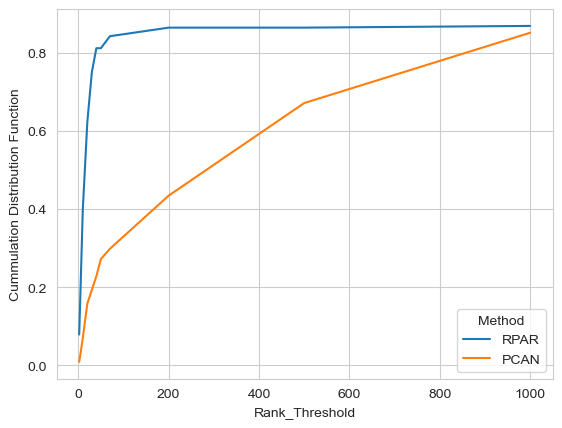

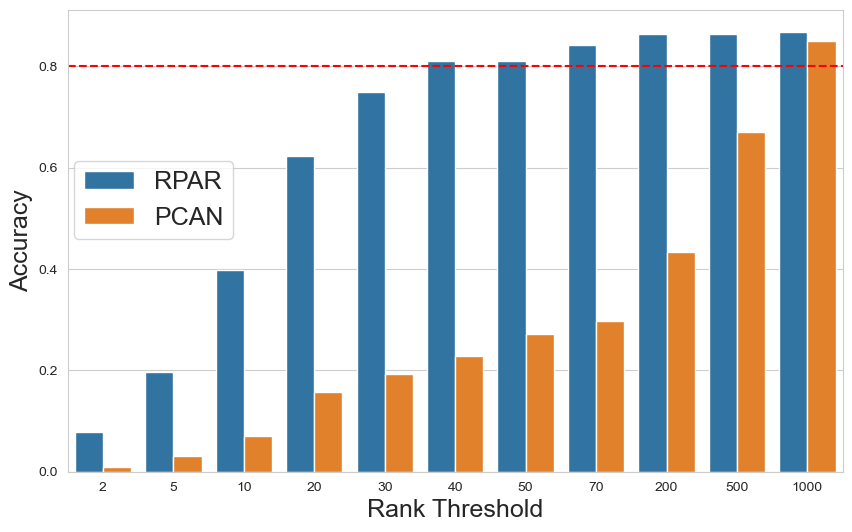

In [186]:
results_old_df = pd.read_csv('results.csv')

phenotype_count = []
for i in results_old_df.hpo_id.tolist():
    phenotype_count.append(len(i.split(',')))

results_old_df['phenotype_count'] = phenotype_count
results_old_filtered_df = results_old_df[['case_id', 'L1_cs_rank', 'Rank_PCAN']]
results_old_filtered_df = results_old_filtered_df[results_old_df['L1_cs_rank'] < 27600]


from sklearn.metrics import recall_score, precision_score, auc
from sklearn.metrics import roc_auc_score
plot_df = results_old_filtered_df.copy()
#plot_df = plot_df.drop(['gene_id', 'serial', 'hpo_id'], axis=1)
print(plot_df)
plot_df.columns = ['case_id', "RPAR", "PCAN"]
plot_df = plot_df.melt(id_vars=['case_id'])

plot_df.columns = ['SL2_ID', 'Method', 'Rank']
#plot_df
methods_list = list(set(plot_df.Method.tolist()))
rank_threshold = [2, 5, 10, 20, 30, 40, 50, 70, 200, 500, 1000]
result_list = []
method_aucpr = {}
for j in rank_threshold:
    for i in methods_list:
        med_df = plot_df[plot_df['Method'] == i]
        med_df['results'] = np.where(med_df.Rank < j, 1, 0)
        med_df['yact'] = 1
        recall = recall_score(med_df.yact.values, med_df.results.values)
        precision = precision_score(med_df.yact.values, med_df.results.values)
        accuracy = accuracy_score(med_df.yact.values, med_df.results.values)
        
        out = [i, j, precision, recall, accuracy]
        result_list.append(out)

sens_result_df = pd.DataFrame(result_list)
sens_result_df.columns = ['Method', 'Rank_Threshold', 'Precision', 'Cummulation Distribution Function', 'Accuracy']

sns.lineplot(x='Rank_Threshold', y='Cummulation Distribution Function', data=sens_result_df, hue='Method')


plt.figure(figsize=(10, 6))
sns.barplot(data=sens_result_df, x='Rank_Threshold', y='Accuracy', hue='Method')
plt.axhline(y=0.8, color='red', linestyle='--')
plt.xlabel('Rank Threshold', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(fontsize=18, bbox_to_anchor=(0.23, 0.7))

<Axes: xlabel='Rank_PCAN', ylabel='L1_cs_rank'>

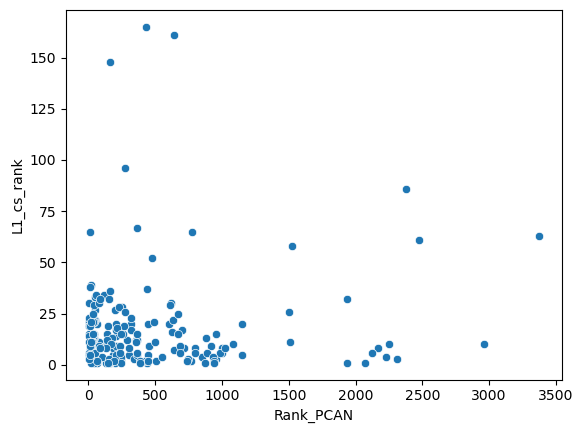

In [110]:
new_results_df = results_old_df[results_old_df['L1_cs_rank'] < 15000]
sns.scatterplot(new_results_df, x='Rank_PCAN', y='L1_cs_rank')

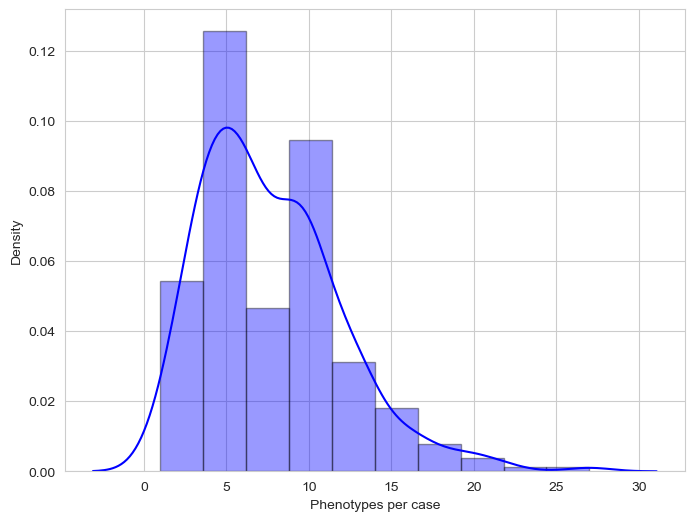

In [145]:
phenotype_count = []
for i in results_old_df.hpo_id.tolist():
    phenotype_count.append(len(i.split(',')))


plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")  # Set the style of the plot

# Use sns.distplot() to create a distribution plot
sns.distplot(phenotype_count, hist=True, kde=True, bins=10, color='blue', hist_kws={'edgecolor': 'black'})

# Add labels and title
plt.xlabel('Phenotypes per case')
plt.ylabel('Density')
#plt.title('Distribution of Values')

# Show the plot
plt.show()

R-squared: 0.01


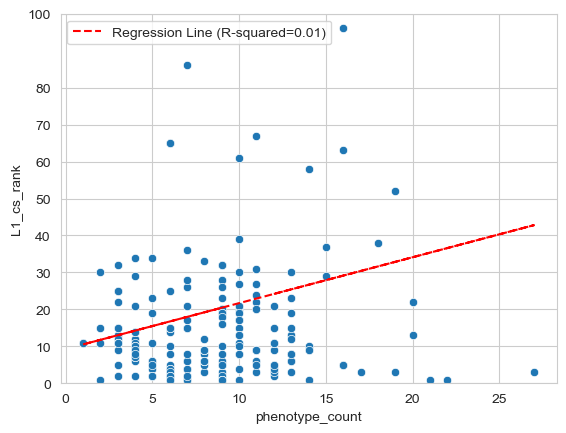

In [140]:
import statsmodels.api as sm
results_old_phen_df = results_old_df[['case_id', 'Rank_PCAN', 'L1_cs_rank', 'phenotype_count']]
results_old_phen_df = results_old_phen_df[results_old_phen_df['L1_cs_rank'] < 1800]
results_old_phen_df

#fig = plt.figure(figsize=(10, 8))
#ax = fig.add_subplot(111, projection='3d')  # Add a 3D projection

# Use Matplotlib's scatter function for 3D
#ax.scatter(results_old_phen_df['Rank_PCAN'], results_old_phen_df['L1_cs_rank'], results_old_phen_df['phenotype_count'], s=100)

# Set labels for the axes
#ax.set_xlabel('Rank_PCAN')
#ax.set_ylabel('L1_cs_rank')
#ax.set_zlabel('phenotype_count')

# Set the title
#ax.set_title('3D Scatter Plot')

# Show the plot
data = results_old_phen_df  # Replace with your DataFrame

# Create a scatter plot
sns.scatterplot(data=data, y='L1_cs_rank', x='phenotype_count')

# Set custom y-axis limits and ticks
y_ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100]
plt.ylim(min(y_ticks), max(y_ticks))
plt.yticks(y_ticks)

# Add a regression line
x = data['phenotype_count']
y = data['L1_cs_rank']
x = sm.add_constant(x)  # Add a constant for the intercept
model = sm.OLS(y, x).fit()
abline_values = [model.params['const'] + model.params['phenotype_count'] * x for x in data['phenotype_count']]
plt.plot(data['phenotype_count'], abline_values, 'r--', label=f'Regression Line (R-squared={model.rsquared:.2f})')

# Compute and print R-squared
r_squared = model.rsquared
print(f'R-squared: {r_squared:.2f}')

# Show the plot
plt.legend()
plt.show()


R-squared: nan


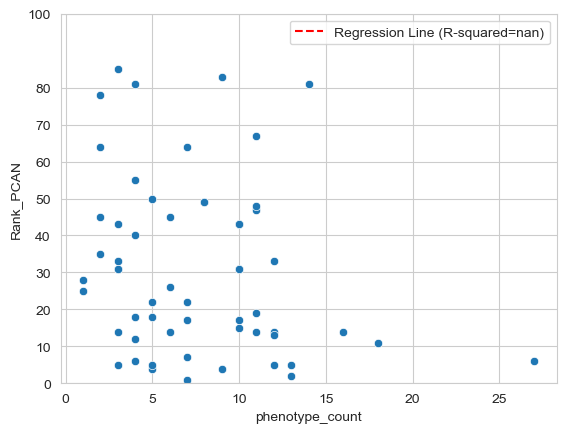

In [143]:
# Show the plot
data = results_old_phen_df  # Replace with your DataFrame

sns.scatterplot(data=data, y='Rank_PCAN', x='phenotype_count')

# Set custom y-axis limits and ticks
#y_ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100]
plt.ylim(min(y_ticks), max(y_ticks))
plt.yticks(y_ticks)

# Add a regression line
x = data['phenotype_count']
y = data['Rank_PCAN']
x = sm.add_constant(x)  # Add a constant for the intercept
model = sm.OLS(y, x).fit()
abline_values = [model.params['const'] + model.params['phenotype_count'] * x for x in data['phenotype_count']]
plt.plot(data['phenotype_count'], abline_values, 'r--', label=f'Regression Line (R-squared={model.rsquared:.2f})')

# Compute and print R-squared
r_squared = model.rsquared
print(f'R-squared: {r_squared:.2f}')

# Show the plot
plt.legend()
plt.show()